# Resume Parsing

## 1. Load data

In [182]:
import pandas as pd
import numpy as np
import json

df_resume = pd.read_csv("data/resume.csv")

In [183]:
df_resume.Category.unique()

array(['HR', 'DESIGNER', 'INFORMATION-TECHNOLOGY', 'TEACHER', 'ADVOCATE',
       'BUSINESS-DEVELOPMENT', 'HEALTHCARE', 'FITNESS', 'AGRICULTURE',
       'BPO', 'SALES', 'CONSULTANT', 'DIGITAL-MEDIA', 'AUTOMOBILE',
       'CHEF', 'FINANCE', 'APPAREL', 'ENGINEERING', 'ACCOUNTANT',
       'CONSTRUCTION', 'PUBLIC-RELATIONS', 'BANKING', 'ARTS', 'AVIATION'],
      dtype=object)

In [184]:
df_resume.shape

(2484, 4)

In [185]:
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))
df_resume = df_resume.copy().iloc[:1000, ]
df_resume.shape

(1000, 4)

## 2. Load skill data

If we define patterns for all the skill, we gonna be too tired.

So spacy knows that, so it allows you to give you a list of words, then it will automatically create pattern.

In [186]:
import spacy

nlp = spacy.load('en_core_web_md')
skill_path      = 'data/skills.jsonl'
skill_ai_path   = 'data/skill_ai.jsonl'
skill_edu_path  = 'data/skills_profession.jsonl'

ruler = nlp.add_pipe("entity_ruler", before='ner')

In [187]:
def load_pattern(file_path):
    pattern = []
    with open(file_path, "r", encoding="utf-8") as file:
        for line in file:
            # Parse JSON from each line
            skill_data = json.loads(line)

            pattern.append(skill_data)
            
    return pattern

In [188]:
skill_pattern = load_pattern(skill_path)
skill_ai_pattern = load_pattern(skill_ai_path)
skill_edu_pattern = load_pattern(skill_edu_path)

In [189]:
ruler.add_patterns(skill_pattern)
ruler.add_patterns(skill_ai_pattern)
ruler.add_patterns(skill_edu_pattern)

In [190]:
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'entity_ruler',
 'ner']

In [191]:
doc = nlp("Chaky loves ajax.")
doc.ents

(Chaky, ajax)

### Add More patterns

In [192]:
ph_no_patterns = [
    {"label": "PHONE_NUMBER", "pattern": [{"ORTH": "("},  {"SHAPE": "ddd"}, {"ORTH": ")"}, {"SHAPE": "ddd"},
                                            {"ORTH": "-", "OP": "?"}, {"SHAPE": "dddd"}]}
]
ruler.add_patterns(ph_no_patterns)

In [193]:
doc = nlp("My name is Wut Yee Aung. My friends call me Putoo")

for ent in doc.ents:
    print(ent.text, ent.label_)

Wut Yee Aung PERSON


In [194]:
email_pattern = [
    {"label": "EMAIL", "pattern": [{"TEXT": {"REGEX": r"[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}"}}]}
]
ruler.add_patterns(email_pattern)

In [195]:
doc = nlp("My email is st124377@ait.asia.")

for ent in doc.ents:
    print(ent.text, ent.label_)

st124377@ait.asia EMAIL


In [196]:
edu_patterns = [
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["bsc", "bachelor", "bachelor's", "b.a", "b.s", "b.c.sc"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["msc", "master", "master's", "m.a", "m.s"]}}, {"IS_ALPHA": True, "OP": "*"}]},
    {"label": "EDUCATION", "pattern": [{"LOWER": {"IN": ["phd", "ph.d", "doctor", "doctorate"]}}, {"IS_ALPHA": True, "OP": "*"}]}
]
ruler.add_patterns(edu_patterns)

In [197]:
doc = nlp("My degree is Bachelor of Computer Science. Normally we say B.C.Sc")

for ent in doc.ents:
    print(ent.text, ent.label_)

Bachelor of Computer Science EDUCATION
B.C.Sc EDUCATION


## 3. Let's try to extract skills from this resume.csv

In [198]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1892,20082776,SENIOR ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT
1451,91268638,EVENT LEAD / PREP COOK / ASSISTANT PA...,"<div class=""fontsize fontface vmargins hmargin...",CHEF
2262,39142536,ACCOUNT EXECUTIVE Profile In...,"<div class=""fontsize fontface vmargins hmargin...",BANKING
300,16533554,INFORMATION TECHNOLOGY MANAGER / NETW...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY
613,81310245,BUSINESS DEVELOPMENT EXECUTIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT


In [199]:
#clean our data
from spacy.lang.en.stop_words import STOP_WORDS

def preprocessing(sentence):
    stopwords    = list(STOP_WORDS)
    doc          = nlp(sentence)
    clean_tokens = []
    
    for token in doc:
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SYM' and \
            token.pos_ != 'SPACE':
                clean_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(clean_tokens)

In [200]:
random_resume = df_resume.Resume_str.iloc[5]
random_resume[:300]

'         STAFF ACCOUNTANT                 Experience         August 2013   to   Current     Company Name   -   City  ,   State      Accounting Manger\t\t\t\t\t\t\tReport to CFO Manages 4 colleagues.  The accounting department consists of 2 Accounting Clerks, 1 Financial Analyst, and 1 Volunteer.  Lead pers'

In [201]:
preprocessing(random_resume[:300])

'staff accountant experience august 2013 current company name city state accounting manger report cfo manages 4 colleague the accounting department consist 2 accounting clerks 1 financial analyst 1 volunteer lead per'

In [202]:
for i, row in df_resume.iterrows():
    clean_text = preprocessing(row.Resume_str)
    df_resume.at[i, 'Clean_resume'] = clean_text

In [203]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1892,20082776,SENIOR ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,senior accountant summary 11 + year experience...
1451,91268638,EVENT LEAD / PREP COOK / ASSISTANT PA...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,event lead prep cook assistant pastry chef sum...
2262,39142536,ACCOUNT EXECUTIVE Profile In...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,account executive profile innovative senior ac...
300,16533554,INFORMATION TECHNOLOGY MANAGER / NETW...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,information technology manager network enginee...
613,81310245,BUSINESS DEVELOPMENT EXECUTIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development executive professional su...


## 4. Let's really extract skills!!

In [204]:
def get_skills(text):
    
    doc = nlp(text)
    
    skills = []
    
    for ent in doc.ents:
        if ent.label_ == 'SKILL':
            skills.append(ent.text)
            
    return skills

def unique_skills(x):
    return list(set(x))

In [205]:
df_resume['Skills'] = df_resume.Clean_resume.apply(get_skills)
df_resume['Skills'] = df_resume.Skills.apply(unique_skills)

In [221]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,Skills
1892,20082776,SENIOR ACCOUNTANT Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ACCOUNTANT,senior accountant summary 11 + year experience...,"[compliance, project, compilation, reviews, lo..."
1451,91268638,EVENT LEAD / PREP COOK / ASSISTANT PA...,"<div class=""fontsize fontface vmargins hmargin...",CHEF,event lead prep cook assistant pastry chef sum...,"[family, box, private dining, store, chef, com..."
2262,39142536,ACCOUNT EXECUTIVE Profile In...,"<div class=""fontsize fontface vmargins hmargin...",BANKING,account executive profile innovative senior ac...,"[apc, software, processing, underwriting, spen..."
300,16533554,INFORMATION TECHNOLOGY MANAGER / NETW...,"<div class=""fontsize fontface vmargins hmargin...",INFORMATION-TECHNOLOGY,information technology manager network enginee...,"[intel, deployment, operating systems, communi..."
613,81310245,BUSINESS DEVELOPMENT EXECUTIVE ...,"<div class=""fontsize fontface vmargins hmargin...",BUSINESS-DEVELOPMENT,business development executive professional su...,"[communication, articulate, writing, b2b, acco..."


In [206]:
df_resume.Skills.iloc[0]

['compliance',
 'project',
 'compilation',
 'reviews',
 'lotus',
 '2010',
 'pro',
 'resolve',
 'regulatory reporting',
 'tax',
 'productivity',
 'revenue',
 'problem solving',
 'w-2',
 'audit',
 'surety',
 'process',
 'disbursement',
 'billing',
 'office',
 'use tax',
 'compensation',
 'sage',
 'financial statement analysis',
 'inventory management',
 '11',
 'commission',
 'analytical review',
 'insurance',
 'tax preparation',
 'research',
 'security',
 'tax software',
 'analytical reasoning',
 'partnership',
 'business',
 'multi - state sales tax',
 'peachtree',
 '12',
 'financial statements',
 '17',
 'billing process',
 'k-1',
 'general',
 'full cycle',
 'reconcile',
 'tax accounting',
 'inventory',
 'certificate',
 'liaison',
 'regulatory filings',
 'non - profit',
 'se',
 '2007',
 'c',
 'withholding',
 'workers compensation',
 '3',
 'cash',
 '1120s',
 'filing',
 'customer',
 'payroll',
 'government',
 '10',
 'contractors',
 'preparation',
 'consignment',
 'account reconciliation',


## 5. Visualization

Which skills is most important in information management?

In [207]:
set(df_resume.Category)

{'ACCOUNTANT',
 'ADVOCATE',
 'AGRICULTURE',
 'APPAREL',
 'ARTS',
 'AUTOMOBILE',
 'AVIATION',
 'BANKING',
 'BPO',
 'BUSINESS-DEVELOPMENT',
 'CHEF',
 'CONSTRUCTION',
 'CONSULTANT',
 'DESIGNER',
 'DIGITAL-MEDIA',
 'ENGINEERING',
 'FINANCE',
 'FITNESS',
 'HEALTHCARE',
 'HR',
 'INFORMATION-TECHNOLOGY',
 'PUBLIC-RELATIONS',
 'SALES',
 'TEACHER'}

In [208]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category

df_resume_it = df_resume[cond]
df_resume_it.shape

(47, 6)

In [209]:
all_skills = np.concatenate(df_resume_it.Skills.values)

In [210]:
from collections import Counter, OrderedDict

counting = Counter(all_skills)
counting = OrderedDict(counting.most_common(10))

In [211]:
counting

OrderedDict([('information technology', 46),
             ('support', 43),
             ('system', 42),
             ('software', 39),
             ('it', 38),
             ('technology', 37),
             ('business', 37),
             ('technical', 37),
             ('training', 36),
             ('management', 36)])

<BarContainer object of 10 artists>

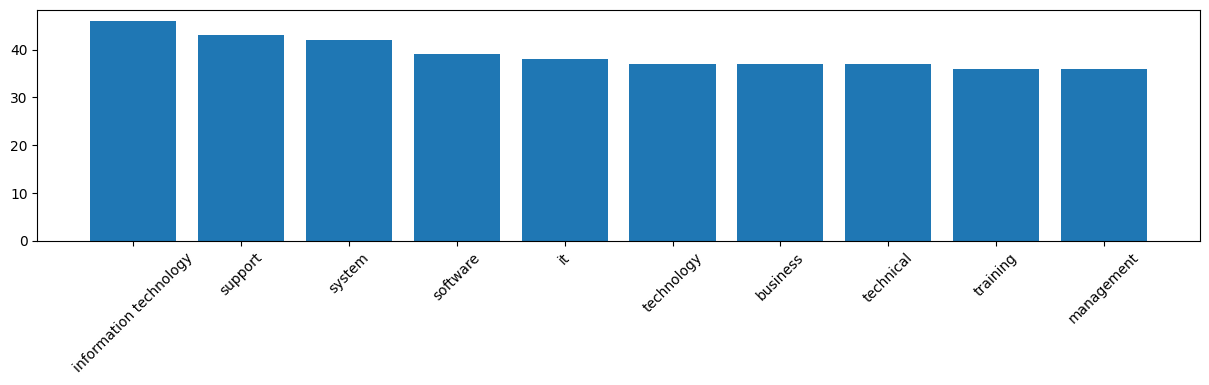

In [212]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
plt.xticks(rotation=45)

plt.bar(counting.keys(), counting.values())

## 6. Name Entity Recognition

In [213]:
from spacy import displacy

text = df_resume_it.Clean_resume.iloc[32]

In [214]:
doc = nlp(text)

In [220]:
# colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
# options = {"colors": colors}

colors = {
    "PERSON": "linear-gradient(90deg, #aa9fff, #fc9cf7)",
    "SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "EDUCATION": "linear-gradient(90deg, #ADD8E6, #fc9ce7)",
    "PHONE_NUMBER": "linear-gradient(90deg, #87CEEB, #FFA07A)",
    "EMAIL": "linear-gradient(90deg, #98FB98, #FFD700)"
}
options = {"colors": colors}

displacy.render(doc, style='ent', options=options)

## 7. Let's load the PDF - add some realism

In [216]:
from PyPDF2 import PdfReader

reader = PdfReader("data/chaklam_resume.pdf")
page = reader.pages[0]
text = page.extract_text()

In [217]:
text = preprocessing(text)

In [218]:
doc = nlp(text)

In [219]:
displacy.render(doc, style='ent', options=options)